In [44]:
import torch
import pandas as pd
import torch.nn as nn
import pytorch_lightning as pl
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms


class DINO_4k_feature_dataset(Dataset):
    def __init__(self, target):
        features = pd.read_csv('/home/rens/repos/premium_pathology/hipt_feature_extractor/data/features.csv').set_index('Unnamed: 0')
        labels = pd.read_csv('/home/rens/repos/premium_pathology/hipt_feature_extractor/data/labels.csv').set_index('Unnamed: 0')
        labels.index = [Path(ix).stem for ix in labels.index]

        self.target = target

        self.data = features.join(labels[target], on='slide')
        self.data[target] = self.data[target].astype(int)

        self.slides = self.data.slide.unique()
        
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x.float()[0])
        ])

    def __len__(self):
        return len(self.slides)
    
    def __getitem__(self, ix):
        slide = self.slides[ix]

        slide_data = self.data[self.data.slide == slide]

        features = slide_data[[f'feature{f}' for f in range(192)]].to_numpy()
        x = self.transforms(features)

        y = torch.tensor(slide_data[self.target][0]).float()

        return x, y
    

class CLAM_feature_dataset(Dataset):
    def __init__(self, target):
        self.features_root = Path('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files')
        self.labels = pd.read_csv('/home/rens/repos/premium_pathology/hipt_feature_extractor/data/labels_clam.csv').set_index('Unnamed: 0')
        self.labels.index = [Path(ix).stem for ix in self.labels.index]

        self.target = target
        
        self.transforms = transforms.Compose([
            # transforms.ToTensor(),
            transforms.Lambda(lambda x: x.float())
        ])

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, ix):
        x = torch.load(self.features_root / (self.labels.index[ix] + '.pt'))
        x = self.transforms(x)

        y = self.labels.iloc[ix][self.target]
        y = torch.tensor(y).float()

        return x, y
      
        
class GatedAttentionLayer(nn.Module):
    def __init__(self, input_dim, output_dim, dropout=0):
        super().__init__()
        
        self.attention_a = [
            nn.Linear(input_dim,output_dim),
            nn.Tanh()
        ]
        self.attention_b = [
            nn.Linear(input_dim,output_dim),
            nn.Sigmoid()
        ]

        self.attention_c = [
            nn.Linear(output_dim, 1),
            nn.Softmax(dim=1)
        ]

        if dropout:
            self.attention_a.append(nn.Dropout(dropout))
            self.attention_b.append(nn.Dropout(dropout))

        self.attention_a = nn.Sequential(*self.attention_a) 
        self.attention_b = nn.Sequential(*self.attention_b)
        self.attention_c = nn.Sequential(*self.attention_c)

    def forward(self, x):
        a = self.attention_a(x)
        b = self.attention_b(x)
        A = a.mul(b)
        out = self.attention_c(A)

        return out
    
class AttentionModel(pl.LightningModule):
    def __init__(self, dataset, dropout=0):
        super().__init__()

        self.dataset = dataset

        self.attention_layer = GatedAttentionLayer(1024, 128, dropout)
        self.classifier = nn.Sequential(*[
            nn.Linear(1024, 1),
            # nn.ReLU(),
            # nn.Linear(128,128),
            # nn.ReLU(),
            # nn.Linear(128,1),
            nn.Sigmoid()
        ])

        self.criterion = nn.BCELoss()

    def forward(self, x):
        A = self.attention_layer(x).transpose(1,2)
        M = torch.matmul(A, x)
        out = self.classifier(M)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat.squeeze(), y.squeeze())

        self.log('train_loss', loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.criterion(y_hat.squeeze(), y.squeeze())

        self.log('val_loss', loss)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-4)
        return optimizer
    
    def setup(self, **kwargs):
        n = len(self.dataset)
        train_n = int(n*0.8)

        self.train_dataset, self.val_dataset = random_split(self.dataset, [train_n, n-train_n])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = 1)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size = 1)
        

In [69]:
from monai.data import CacheDataset
import monai.transforms

class LoadTensor(monai.transforms.MapTransform):
    def __init__(self, keys):
        self.keys=keys
    def __call__(self, data):
        for key in self.keys:
            data[key] = torch.load(data[key])
        return data

class CLAM_cache_feature_dataset(CacheDataset):
    def __init__(self, target):
        features_root = Path('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files')
        labels = pd.read_csv('/home/rens/repos/premium_pathology/hipt_feature_extractor/data/labels_clam.csv').set_index('Unnamed: 0')
        labels.index = [Path(ix).stem for ix in labels.index]

        data = [{'x':features_root / (path + '.pt'), 'y':label, 'id':path} for (path,label) in labels[target].iteritems()]
        
        transform = monai.transforms.Compose([
            LoadTensor(keys=['x']),
            monai.transforms.Lambdad(keys=['y'], func=lambda y: torch.tensor(y).float()),
        ])

        super().__init__(data, transform, num_workers=12, cache_num=24)

ds = CLAM_cache_feature_dataset('primary')

/tmp/ipykernel_664/2070370792.py:21: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  data = [{'x':features_root / (path + '.pt'), 'y':label, 'id':path} for (path,label) in labels[target].iteritems()]


loading
loading
loading
loading
loading
loading


loading
loading
loaded
loading
loaded
loaded


loading
loaded
loaded
loading
loaded
loaded
loading
loaded
loading
loading
loading
loading


In [67]:
dl = DataLoader(ds, batch_size=1)

In [68]:
next(iter(dl))

loading
loaded


{'x': tensor([[[0.1025, 0.0098, 0.0045,  ..., 0.0219, 0.0600, 0.0123],
          [0.1138, 0.0096, 0.0140,  ..., 0.0234, 0.0750, 0.0211],
          [0.0972, 0.0157, 0.0197,  ..., 0.0239, 0.0219, 0.0045],
          ...,
          [0.0881, 0.0059, 0.0058,  ..., 0.0396, 0.0531, 0.0113],
          [0.0956, 0.0028, 0.0097,  ..., 0.0193, 0.0422, 0.0240],
          [0.1013, 0.0119, 0.0185,  ..., 0.0286, 0.0254, 0.0034]]]),
 'y': tensor([0.])
 Metadata
 	affine: tensor([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=torch.float64)
 	space: RAS
 
 Applied operations
 [{class: 'Lambda', id: 140022413140720, orig_size: ()}]
 Is batch?: False,
 'id': ['PREM_ZU_038 - T20-020312-I-S-1 - 2021-08-12 15.16.35']}

In [46]:
features_root = Path('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files')
labels = pd.read_csv('/home/rens/repos/premium_pathology/hipt_feature_extractor/data/labels_clam.csv').set_index('Unnamed: 0')
labels.index = [Path(ix).stem for ix in labels.index]


/tmp/ipykernel_664/437213595.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [{'x':features_root / (path + '.pt'), 'y':label, 'id':path} for (path,label) in labels['primary'].iteritems()]


[{'x': PosixPath('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files/PREM_ZU_038 - T20-020312-I-S-1 - 2021-08-12 15.16.35.pt'),
  'y': False,
  'id': 'PREM_ZU_038 - T20-020312-I-S-1 - 2021-08-12 15.16.35'},
 {'x': PosixPath('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files/PREM_VU_008_ eeb94e7e4a - 2022-11-10 11.22.27.pt'),
  'y': True,
  'id': 'PREM_VU_008_ eeb94e7e4a - 2022-11-10 11.22.27'},
 {'x': PosixPath('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files/PREM_VU_102 71d95b93cb - 2022-06-14 11.49.03.pt'),
  'y': False,
  'id': 'PREM_VU_102 71d95b93cb - 2022-06-14 11.49.03'},
 {'x': PosixPath('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files/PREM_ZU_036 - T17-5592534 - 2021-08-13 14.03.27.pt'),
  'y': False,
  'id': 'PREM_ZU_036 - T17-5592534 - 2021-08-13 14.03.27'},
 {'x': PosixPath('/mnt/hpc/pathology/clam_features/primary_vs_metastasis/pt_files/MAX-135 7c594aacd2 - 2022-09-29 11.53.53.pt'),
  'y': False,
  'id': 'MAX-135 7

In [43]:
import wandb
from pytorch_lightning.loggers import WandbLogger

dataset = CLAM_feature_dataset(target='primary')
model = AttentionModel(dataset)

logger = WandbLogger(project='pathology', name='debug_attention_on_clam_features')

trainer = pl.Trainer(
    accelerator='gpu',
    accumulate_grad_batches=64,
    logger=logger
    # overfit_batches=10
)

trainer.fit(model)

wandb.finish()

/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                | Params
--------------------------------------------------------
0 | attention_layer | GatedAttentionLayer | 262 K 
1 | classifier      | Sequential          | 1.0 K 
2 | criterion       | BCEL

Sanity Checking: 0it [00:00, ?it/s]

/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_664/2385727307.py:65: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y = torch.tensor(y).float()
/home/rens/miniconda3/envs/rens/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

In [17]:
wandb.finish()

epoch,▁▁▁▁▅▅▅▅██▁▁▁▁▁▅▅▅▅
train_loss,▄▇▇▅▃▇▂▃▄▁▂▇▄█▄▄█▇▅
trainer/global_step,▁▂▃▃▄▅▆▆▇█▁▁▂▃▃▄▅▆▆
epoch,1
train_loss,0.67373
trainer/global_step,399


In [3]:
dl = model.train_dataloader()

for batch in dl:
    x, y = batch
    y_hat = model(x)
    break

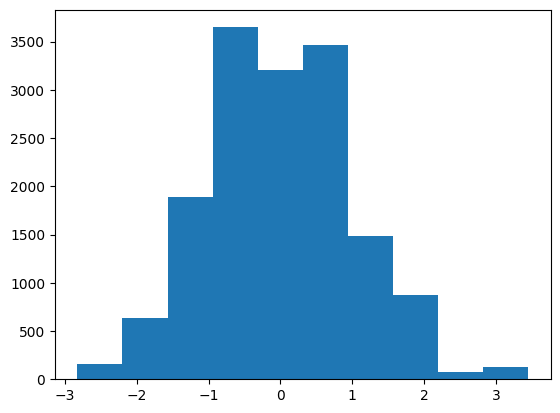

In [5]:
import matplotlib.pyplot as plt

plt.hist(x.numpy().flatten())
plt.show()

In [140]:
y.shape

torch.Size([1])

In [62]:
x.shape

torch.Size([1, 81, 192])